# Comparing Results

In [1]:
import importlib
import config
import pandas as pd
from pathlib import Path
from config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def get_performance(years, city, nn_type):
    print(f'Loading {nn_type} PINN and MSE performance for {years} in {city}')

    file_templates = {
        'mlp': f'results_{nn_type}_no2_MSE_{years}_{city}.csv',
        'linear': f'results_{nn_type}_no2_LinearShift_MSE_{years}_{city}.csv',
        'pde_eq1': f'results_{nn_type}_no2_PDE_nmer_const_{years}_{city}.csv',
        'pde_eq2': f'results_{nn_type}_no2_PDE_nmer_piece_{years}_{city}.csv',
        'pinn': f'results_{nn_type}_no2_PINN_{years}_{city}.csv',
    }

    results = {}
    for key, filename in file_templates.items():
        file_path = RESULTS_PATH / city / 'metrics' / filename
        if file_path.exists():
            df = pd.read_csv(file_path)
            results[key] = df.iloc[0]
        else:
            print(f"Warning: {file_path} does not exist.")
            results[key] = None

    return results.get('mlp'), results.get('pinn'), results.get('linear'), results.get('pde_eq1'), results.get('pde_eq2')


## Comparing Physics model results

In [3]:
def plot_all_metrics(years, city, nn_type):
    # Get performance data
    mlp, pinn, linear, pde_eq1, pde_eq2 = get_performance(years, city, nn_type)

    models = ['MLP', 'PINN', 'LinearShift', 'PDE_Const', 'PDE_Piece']
    data = [mlp, pinn, linear, pde_eq1, pde_eq2]

    # Metrics to plot
    metric_names = ['MSE', 'RMSE', 'SMAPE', 'Inference Time', 'Training Time']
    num_metrics = len(metric_names)

    # Build metric data dictionary
    metrics_data = {metric: {} for metric in metric_names}
    for model_name, model_metrics in zip(models, data):
        if model_metrics is not None:
            for metric in metric_names:
                if metric in model_metrics:
                    metrics_data[metric][model_name] = model_metrics[metric]
                else:
                    metrics_data[metric][model_name] = None

    # Create a single figure with multiple subplots
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5), constrained_layout=True)

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        model_names = list(metrics_data[metric].keys())
        values = [metrics_data[metric][m] for m in model_names]

        # Filter out None values
        filtered = [(m, v) for m, v in zip(model_names, values) if v is not None]
        if not filtered:
            ax.set_visible(False)
            continue

        model_names, values = zip(*filtered)
        min_val, max_val = min(values), max(values)
        padding = (max_val - min_val) * 0.1 if max_val != min_val else 1
        y_min = max(min_val - padding, 0) if min_val >= 0 else min_val - padding
        y_max = max_val + padding

        ax.bar(model_names, values, color='skyblue')
        ax.set_title(metric)
        ax.set_ylabel(metric)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=30)

    fig.suptitle(f'Model Performance Metrics ({nn_type.upper()}, {years}, {city})', fontsize=16)
    plt.savefig(THESIS_PLOTS_PATH / f'{nn_type}_{city}_{years}_performance_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

Loading MLP PINN and MSE performance for allyears in Utrecht


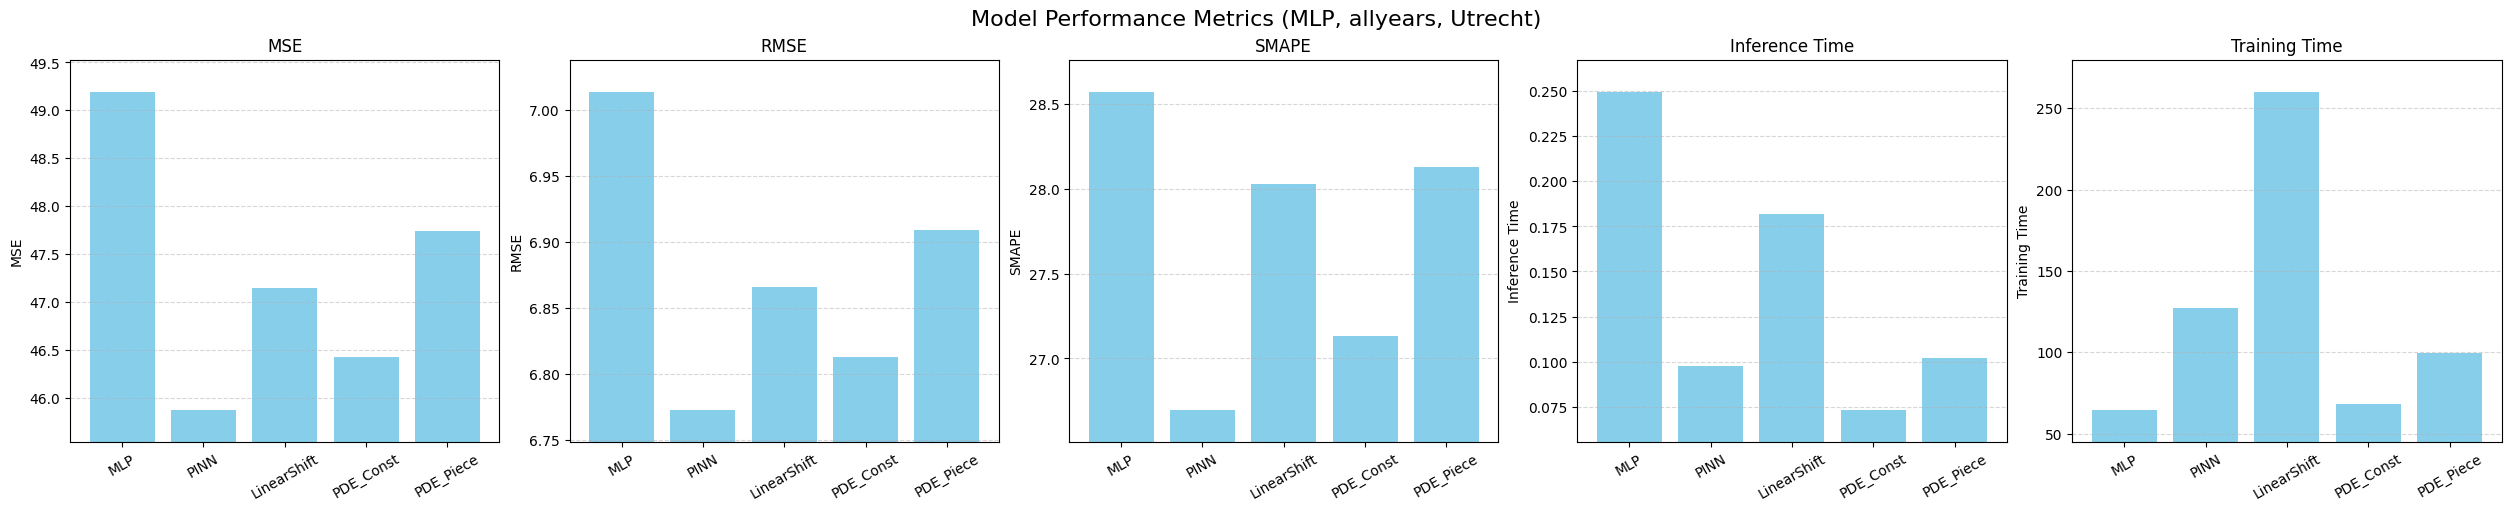

In [4]:
plot_all_metrics(years='allyears', city = 'Utrecht', nn_type='MLP')

## Comparing PINN and Baseline MLP with different data length


In [5]:
def plot_mse_comparison(city, nn_type):
    # Define the three time ranges
    time_ranges = ['2017', 'first_3_years', 'allyears']
    time_range_labels = ['2017 only', 'First 3 years', 'All years']
    
    # Store results
    mlp_mse_values = []
    pinn_mse_values = []

    
    # Assuming there's a column named 'test_mse' - adjust as needed
    mse_column = 'MSE'  # Change this based on your actual data structure
    
    # Collect MSE values for each time range
    for i, years in enumerate(time_ranges):
        mlp_metrics, pinn_metrics, _, _, _ = get_performance(years, city, nn_type)
        print(f'{nn_type} Baseline {years} {city}')
        print(mlp_metrics)
        print(f'{nn_type} PINN {years} {city}')
        print(pinn_metrics)
        
        # Extract MSE values
        mlp_mse = float(mlp_metrics[mse_column])
        pinn_mse = float(pinn_metrics[mse_column])
        
        mlp_mse_values.append(mlp_mse)
        pinn_mse_values.append(pinn_mse)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot lines
    plt.plot(time_range_labels, mlp_mse_values, 'o-', color='blue', linewidth=2, label='Baseline MLP')
    plt.plot(time_range_labels, pinn_mse_values, 'o-', color='red', linewidth=2, label='PINN')
    
    # Fill the area between the lines to highlight the improvement
    plt.fill_between(time_range_labels, mlp_mse_values, pinn_mse_values, 
                     alpha=0.3, color='green', label='PINN improvement')
    
    # Add labels and title
    plt.xlabel('Amount of Training Data', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.title(f'MSE Comparison of {nn_type} in {city}: PINN vs Baseline MLP with Different Amount of Data', fontsize=14)
    
    # Add legend
    plt.legend(fontsize=11)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(THESIS_PLOTS_PATH / f'PINN_improve_{nn_type}_{city}.png', dpi=300, bbox_inches='tight')
    plt.show()

    
    # Display percentage improvements
    improvements = [(mlp - pinn) / mlp * 100 for mlp, pinn in zip(mlp_mse_values, pinn_mse_values)]
    
    print("\nPercentage improvement of PINN over Baseline:")
    for i, label in enumerate(time_range_labels):
        print(f"{label}: {improvements[i]:.2f}%")
        
    return improvements

## Utrecht MLP

In [ ]:
# Run the function
plot_mse_comparison(city = 'Utrecht', nn_type = "MLP")

In [ ]:
plot_mse_comparison(city = 'Multi', nn_type = "MLP")